# Delaware tax and benefit system

This notebook shows how the state and federal tax and benefit system affects Delaware residents holistically.

## Examples

Consider a set of Delaware family types, each with \$1,000 monthly rent and \$50 monthly broadband costs, and varying in terms of marital status and number of children.
Their net income---after state and federal taxes and benefits modeled by PolicyEngine US---is shown in the graph below.

*The cliff is due to Delaware's emergency SNAP allotment, which entitles SNAP-eligible households to the maximum benefit for their household size; this also affects other benefits through categorical eligibility.*

In [1]:
from policyengine_us import IndividualSim
import pandas as pd
import plotly.express as px

LIGHT_GRAY = "#F5F5F5"
GRAY = "#BDBDBD"
BLUE = "#5091cc"
LIGHT_BLUE = "lightblue"
DARK_BLUE = "darkblue"


def make_tax(adults, children):
    sim = IndividualSim(year=2023)
    sim.add_person(name="head", age=25, rent=12_000)
    members = ["head"]
    if adults == 2:
        sim.add_person(name="spouse", age=25)
        members += ["spouse"]
    for i in range(children):
        child = "child{}".format(i)
        sim.add_person(name=child, age=6)
        members += [child]
    sim.add_tax_unit(name="tax_unit", members=members, premium_tax_credit=0)
    # $1,000 monthly rent, $50 monthly broadband.
    sim.add_spm_unit(name="spm_unit", members=members, broadband_cost=600)
    sim.add_household(name="household", members=members, state_code="DE")
    sim.vary("employment_income", max=100_000, step=100)
    employment_income = sim.calc("employment_income")[0]
    spm_unit_net_income = sim.calc("spm_unit_net_income")[0].round()
    mtr = 1 - sim.deriv(
        "spm_unit_net_income", "employment_income", wrt_target="head"
    )
    return pd.DataFrame(
        dict(
            employment_income=employment_income,
            spm_unit_net_income=spm_unit_net_income,
            mtr=mtr,
            adults=adults,
            children=str(children),
        )
    )


# Make a table of state taxes for different numbers of adults and children.
l = []
for adults in range(1, 3):
    for children in range(0, 4):
        l.append(make_tax(adults, children))

df = pd.concat(l)

LABELS = dict(
    employment_income="Employment income",
    spm_unit_net_income="Net income",
    mtr="Marginal tax rate",
    adults="Adults",
    children="Children",
)

COLOR_MAP = {"0": GRAY, "1": LIGHT_BLUE, "2": BLUE, "3": DARK_BLUE}

fig = px.line(
    df,
    "employment_income",
    "spm_unit_net_income",
    color="children",
    animation_frame="adults",
    labels=LABELS,
    title="Net income for a Delaware household",
    color_discrete_map=COLOR_MAP,
)
fig.update_layout(
    xaxis_tickformat="$,",
    yaxis_tickformat="$,",
    plot_bgcolor="white",
    xaxis_gridcolor=LIGHT_GRAY,
    yaxis_gridcolor=LIGHT_GRAY,
)
fig.show()

Total marginal tax rates range from below -50% to above 50%.

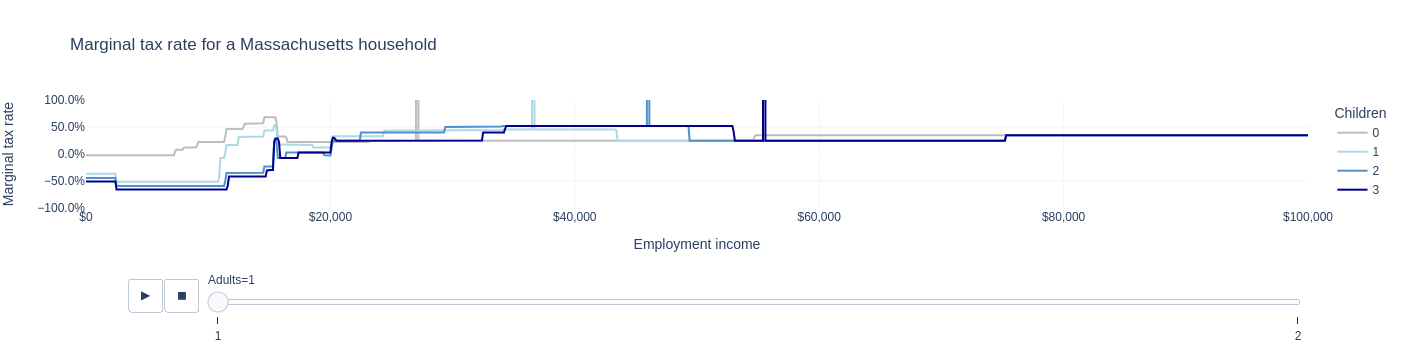

In [2]:
fig = px.line(
    df,
    "employment_income",
    "mtr",
    color="children",
    animation_frame="adults",
    labels=LABELS,
    title="Marginal tax rate for a Delaware household",
    color_discrete_map=COLOR_MAP,
)
fig.update_layout(
    xaxis_tickformat="$,",
    yaxis_tickformat=".1%",
    yaxis_range=[-1, 1],
    plot_bgcolor="white",
    xaxis_gridcolor=LIGHT_GRAY,
    yaxis_gridcolor=LIGHT_GRAY,
)
fig.show()

### Other situations

A single person who is age 65 and holds less than \$2,000 in assets will be eligible for additional tax exemptions and federal Supplemental Security Income (SSI).

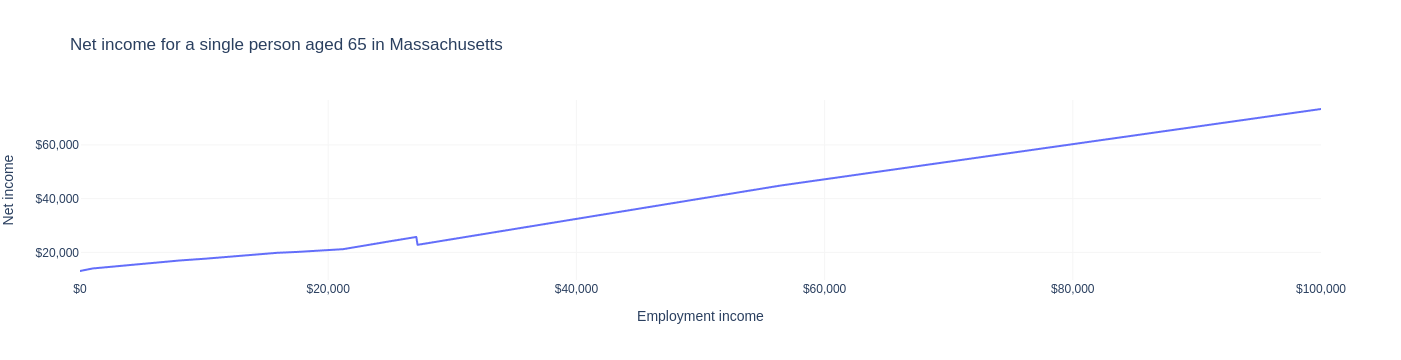

In [3]:
sim = IndividualSim(year=2022)
sim.add_person(name="head", age=65)
sim.add_tax_unit(name="tax_unit", members=["head"], premium_tax_credit=0)
sim.add_spm_unit(name="spmu", members=["head"])
sim.add_household(name="h", members=["head"], state_code="DE")

sim.vary("employment_income", max=100_000, step=100)
employment_income = sim.calc("employment_income")[0]
spm_unit_net_income = sim.calc("spm_unit_net_income")[0].round()
mtr = 1 - sim.deriv(
    "spm_unit_net_income", "employment_income", wrt_target="head"
)
df = pd.DataFrame(
    dict(
        employment_income=employment_income,
        spm_unit_net_income=spm_unit_net_income,
        mtr=mtr,
    )
)

fig = px.line(
    df,
    "employment_income",
    "spm_unit_net_income",
    labels=LABELS,
    title="Net income for a single person aged 65 in Delaware",
)

fig.update_layout(
    xaxis_tickformat="$,",
    yaxis_tickformat="$,",
    plot_bgcolor="white",
    xaxis_gridcolor=LIGHT_GRAY,
    yaxis_gridcolor=LIGHT_GRAY,
)
fig.show()

This single 65-year-old faces marginal tax rates between 57 and 80 percent when they earn between \$1,100 and \$21,300.
Earnings beyond that, up to \$100,000, are subject to marginal tax rates between 22 and 35 percent, except for a cliff when they lose SNAP eligibility at \$25,700 earnings.

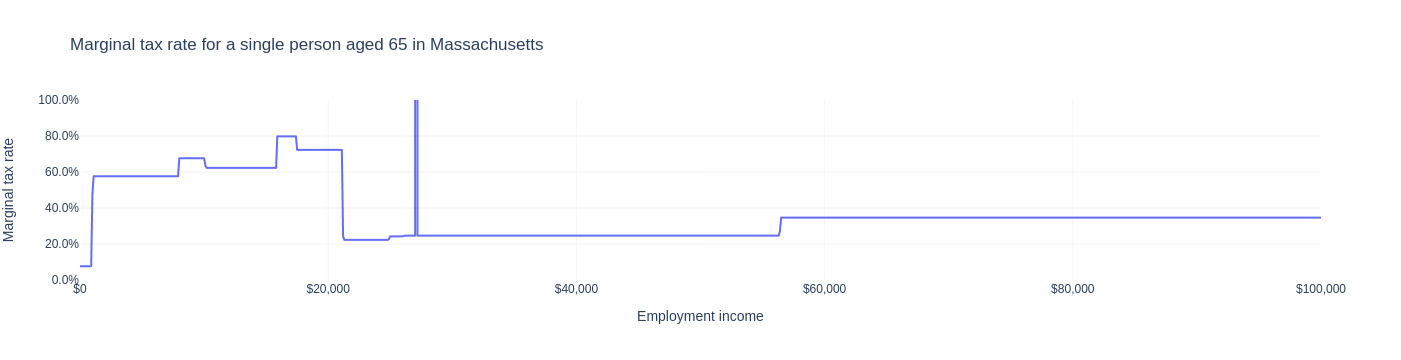

In [4]:
fig = px.line(
    df,
    "employment_income",
    "mtr",
    labels=LABELS,
    title="Marginal tax rate for a single person aged 65 in Delaware",
)

fig.update_layout(
    xaxis_tickformat="$,",
    yaxis_tickformat=".1%",
    yaxis_range=[0, 1],
    plot_bgcolor="white",
    xaxis_gridcolor=LIGHT_GRAY,
    yaxis_gridcolor=LIGHT_GRAY,
)
fig.show()